<a href="https://colab.research.google.com/github/keezu108/bert_cls/blob/main/%E5%88%86%E9%A1%9E(Attention).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

In [ ]:
!pip install transformers
!pip install fugashi
!pip install unidic_lite
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 112.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.9/615.9 KB 18.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic_lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658837 sha256=32a353f02f3af97694b7770b568a8f33984a89b8046989d3d2a395d3bc462b82
  Stored in directory: /root/.cache/pip/wheels/8c/dd/8f/e21fc192dcd38ae31e1185ce4e66e12df4e811e3d

In [ ]:
cd /content/drive/MyDrive/ゼミ

/content/drive/MyDrive/ゼミ


In [ ]:
from transformers import BertModel,AutoTokenizer
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

tokenizer = AutoTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-v2')

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

In [ ]:
class Data(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data["text"].values[idx]
        encoded = tokenizer(text, padding = "max_length", 
                            max_length = self. max_length, 
                            truncation = True)
        ids = torch.tensor(encoded["input_ids"], dtype = torch.int32)
        mask = torch.tensor(encoded["attention_mask"], dtype = torch.int32)
        label = self.data["label"].values[idx]
        label = torch.tensor(label, dtype = torch.int32)
        return ids, mask, label

In [ ]:
class ExtSummarizer(nn.Module):
    def __init__(self):
        super(ExtSummarizer, self).__init__()
        self.bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-v2',
                                              output_attentions=True, output_hidden_states=True)
        self.linear = nn.Linear(768, 2)
    
    def forward(self, ids, mask):
        out = self.bert(ids, attention_mask = mask)
        a = out.attentions
        h = out.pooler_output
        h = self.linear(h)
        #h = h[:, 0]
        a = a[-1].sum(1)[:, 0, :]

        return h, a

In [ ]:
model = ExtSummarizer().cuda()

for param in model.parameters():#全部OFF
    param.requires_grad = False
for param in model.bert.encoder.layer[-1].parameters():
    param.requires_grad = True
for param in model.bert.encoder.layer[-2].parameters():
    param.requires_grad = True
for param in model.bert.encoder.layer[-3].parameters():
    param.requires_grad = True
for param in model.bert.encoder.layer[-4].parameters():
    param.requires_grad = True
for param in model.linear.parameters():#ExtSummarizer
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr = 1e-5)
"""optimizer = optim.Adam([
    {'params': model.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': model.bert.encoder.layer[-2].parameters(), 'lr': 5e-5},
    {'params': model.bert.encoder.layer[-3].parameters(), 'lr': 5e-5},
    {'params': model.bert.encoder.layer[-4].parameters(), 'lr': 5e-5},
    {'params': model.linear.parameters(), 'lr': 2e-5}
])"""

criterion = nn.CrossEntropyLoss()

Downloading:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# データセット

In [ ]:
def ZeroOne(data):
    cnt = data['label'].values.tolist()
    zero = cnt.count(0)
    one = len(cnt) - zero
    return zero, one
    
def dsdl(data, maxlen, batchsize, train=False, test=False):
    dataset = Data(data, tokenizer, maxlen)
    if train == True:
        dataloader = DataLoader(dataset, batch_size = batchsize, 
                                shuffle = False, drop_last = False)
    elif test == True:
        dataloader = DataLoader(dataset, batch_size = len(dataset), 
                                shuffle = False, drop_last = False)
    return dataset, dataloader

In [ ]:
speckled = pd.read_csv("まだらのひも.csv")
dancing = pd.read_csv("踊る人形.csv", encoding="shift-jis")
silver = pd.read_csv("シルヴァブレイズ.csv", encoding="shift-jis")
identity = pd.read_csv("花婿失踪事件.csv", encoding="shift-jis")
patient = pd.read_csv("入院患者.csv", encoding="shift-jis")
crooked = pd.read_csv("背中の曲がった男.csv", encoding="shift-jis")

cnt_speckled = ZeroOne(speckled)
cnt_dancing = ZeroOne(dancing)
cnt_silver = ZeroOne(silver)
cnt_identity = ZeroOne(identity)
cnt_patient = ZeroOne(patient)
cnt_crooked = ZeroOne(crooked)

print(f"まだらのひも：{speckled.shape[0]}, 0: {cnt_speckled[0]}, 1: {cnt_speckled[1]}")
#print(speckled['label'].values)
print(f"踊る人形：{dancing.shape[0]}, 0: {cnt_dancing[0]}, 1: {cnt_dancing[1]}")
#print(dancing['label'].values)
print(f"シルヴァブレイズ：{silver.shape[0]}, 0: {cnt_silver[0]}, 1: {cnt_silver[1]}")
#print(silver['label'].values)
print(f"花婿失踪事件：{identity.shape[0]}, 0: {cnt_identity[0]}, 1: {cnt_identity[1]}")
#print(identity['label'].values)
print(f"入院患者：{patient.shape[0]}, 0: {cnt_patient[0]}, 1: {cnt_patient[1]}")
#print(patient['label'].values)
print(f"背中の曲がった男：{crooked.shape[0]}, 0: {cnt_crooked[0]}, 1: {cnt_crooked[1]}")
#print(patient['label'].values)

まだらのひも：478, 0: 278, 1: 200
踊る人形：497, 0: 315, 1: 182
シルヴァブレイズ：497, 0: 299, 1: 198
花婿失踪事件：378, 0: 146, 1: 232
入院患者：515, 0: 309, 1: 206
背中の曲がった男：374, 0: 176, 1: 198


In [ ]:
train = pd.concat([dancing, silver, identity, patient, crooked], axis=0)
incident = pd.concat([dancing, patient], axis=0)
accident = pd.concat([silver, identity, crooked], axis=0)

cnt_train = ZeroOne(train)
cnt_accident = ZeroOne(accident)
cnt_incident = ZeroOne(incident)

print(f"学習データ：{train.shape[0]}, 0: {cnt_train[0]}, 1: {cnt_train[1]}")
print(f"犯人あり：{incident.shape[0]}, 0: {cnt_incident[0]}, 1: {cnt_incident[1]}")
print(f"犯人なし：{accident.shape[0]}, 0: {cnt_accident[0]}, 1: {cnt_accident[1]}")

学習データ：2261, 0: 1245, 1: 1016
犯人あり：1012, 0: 624, 1: 388
犯人なし：1249, 0: 621, 1: 628


In [ ]:
MAX_LEN = 110
BATCH_SIZE = 8

speckled_ds, speckled_dl = dsdl(speckled, MAX_LEN, BATCH_SIZE, test=True)
train_ds, train_dl = dsdl(train, MAX_LEN, BATCH_SIZE, train=True)
incident_ds, incident_dl = dsdl(incident, MAX_LEN, BATCH_SIZE, train=True)
accident_ds, accident_dl = dsdl(accident, MAX_LEN, BATCH_SIZE, train=True)

# データ可視化

MAX train_length: 104
MAX test_length: 82


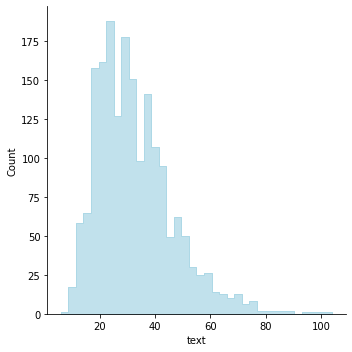

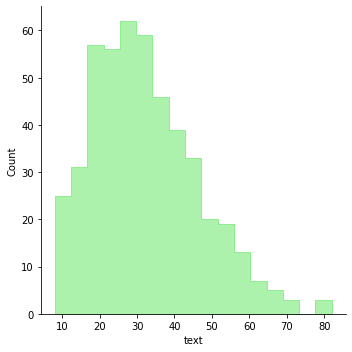

In [ ]:
train_length = train['text'].map(tokenizer.encode).map(len)
test_length = speckled['text'].map(tokenizer.encode).map(len)
#test2_length = test2['text'].map(tokenizer.encode).map(len)
print("MAX train_length:",max(train_length))
print("MAX test_length:",max(test_length))
#print("MAX test2_length:",max(test2_length))
sns.displot(train_length, element='step', kde=False, color='lightblue')
sns.displot(test_length, element='step', kde=False, color='lightgreen')
#sns.displot(test2_length, element='step', kde=False, color='lightgreen')

# 学習

In [ ]:
def model_train(model, optimizer, num_epochs, dataloader):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()#初期化
            ids = batch[0].cuda()
            mask = batch[1].cuda()
            label = batch[2].long().cuda()
            preds, _ = model(ids, mask) # 予測計算
            loss = criterion(preds, label)#損失計算
            loss.backward()#誤差伝搬
            optimizer.step()#パラメータ修正
            train_loss += loss.item()
        train_loss /= len(train_dl)
        print(f"EPOCH:[{epoch+1}]")
        print(f"TRAINLOSS: {train_loss}")
    torch.save(model.state_dict(), "model.pth")

In [ ]:
model_train(model, optimizer, 10, train_dl)

EPOCH:[1]
TRAINLOSS: 0.6592288940829018
EPOCH:[2]
TRAINLOSS: 0.5875922266670335
EPOCH:[3]
TRAINLOSS: 0.5373914581410877
EPOCH:[4]
TRAINLOSS: 0.4732012926163185
EPOCH:[5]
TRAINLOSS: 0.40202068803377794
EPOCH:[6]
TRAINLOSS: 0.3098302741959533
EPOCH:[7]
TRAINLOSS: 0.227269393612397
EPOCH:[8]
TRAINLOSS: 0.15382798844718049
EPOCH:[9]
TRAINLOSS: 0.10715400881723043
EPOCH:[10]
TRAINLOSS: 0.08379464172149347


In [ ]:
model_train(model, optimizer, 10, train_dl)

In [ ]:
model_train(model, optimizer, 10, accident_dl)#犯人なし

In [ ]:
model_train(model, optimizer, 10, incident_dl)#犯人あり

# 精度平均

In [ ]:
def acc_ave(optimizer, num_epochs, loop, dataloader):
    for i in range(loop):
        model = ExtSummarizer().cuda()
        for param in model.parameters():
            param.requires_grad = False
        for param in model.bert.encoder.layer[-1].parameters():
            param.requires_grad = True
        for param in model.linear.parameters():
            param.requires_grad = True

        optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)
        print(f"#{i+1}")
        for epoch in range(num_epochs):
            model.train()
            for batch in dataloader:
                optimizer.zero_grad()
                ids = batch[0].cuda()
                mask = batch[1].cuda()
                label = batch[2].long().cuda()
                preds, _ = model(ids, mask) 
                loss = criterion(preds, label)
                loss.backward()
                optimizer.step()       

        pred = []
        truth = speckled["label"].values.tolist()
        model.eval()
        with torch.no_grad():
            for batch in speckled_dl:
                ids = batch[0].cuda()
                mask = batch[1].cuda()
                logits, _ = model(ids,mask)
                _, logits = torch.max(logits, 1)
                pred += list(logits.cpu().numpy())

        acc, pre, rec, f  = [[] for i in range(4)]
        acc.append(accuracy_score(truth, pred))
        pre.append(precision_score(truth, pred))
        rec.append(recall_score(truth, pred))
        f.append(f1_score(truth, pred))

    accuracy = sum(acc)/len(acc)
    precision = sum(pre)/len(pre)
    recall = sum(rec)/len(rec)
    f1 = sum(f)/len(f)
    print("accuracy:", accuracy.round(2), "precision:", precision.round(2), 
        "recall:", recall.round(2), "f1:", f1.round(2))


In [ ]:
acc_ave(optimizer, 10, 10, accident_dl)#犯人なし

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#1


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#2


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#3


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#4


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#5


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#6


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#7


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#8


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#9


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#10
accuracy: 0.63 precision: 0.54 recall: 0.74 f1: 0.63


In [ ]:
acc_ave(optimizer, 10, 10, incident_dl)#犯人あり

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#1


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#2


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#3


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#4


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#5


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#6


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#7


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#8


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#9


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#10
accuracy: 0.7 precision: 0.65 recall: 0.6 f1: 0.62


# テスト

In [ ]:
def test_score(test, test_dl):
    pred = []
    model.load_state_dict(torch.load('model.pth'))
    model.eval()
    with torch.no_grad():
        for batch in test_dl:
            ids = batch[0].cuda()
            mask = batch[1].cuda()
            logits, _ = model(ids,mask)
            _, logits = torch.max(logits, 1)
            pred += list(logits.cpu().numpy())

    truth = test["label"].values.tolist()
    print(f"予測：{pred}")
    print(f"正解：{truth}")

    labels = [1,0]
    cm = confusion_matrix(truth, pred, labels=labels)
    columns_labels = ["pred_" + str(l) for l in labels]
    index_labels = ["truth_" + str(l) for l in labels]
    cm = pd.DataFrame(cm, columns=columns_labels, index=index_labels)
    print(cm.to_markdown())

    accuracy = accuracy_score(truth, pred)
    precision = precision_score(truth, pred)
    recall = recall_score(truth, pred)
    f1 = f1_score(truth, pred)
    print("accuracy:", accuracy.round(2), "precision:", precision.round(2), 
        "recall:", recall.round(2), "f1:", f1.round(2))

In [ ]:
test_score(speckled, speckled_dl)

予測：[0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

# テスト結果

In [ ]:
def PT(test, pred, truth):
    p1t1, p1t0, p0t0, p0t1, summary, not_summary, result = [[] for i in range(7)]
    for i, (p, t) in enumerate(zip(pred, truth)):
        if p == 1 and t == 1:
            p1t1.append(test["text"].values[i])
        elif p == 1 and t == 0:
            p1t0.append(test["text"].values[i])
        elif p == 0 and t == 0:
            p0t0.append(test["text"].values[i])
        elif p == 0 and t == 1:
            p0t1.append(test["text"].values[i])

    for id, value in enumerate(pred):
        if value==1:
            summary.append(test["text"].values[id])
            result.append("#" + test["text"].values[id])
        else:
            not_summary.append(test["text"].values[id])
            result.append(test["text"].values[id])
    print(f"summary:{len(summary)}, not_summary:{len(not_summary)}")

    return p1t1, p1t0, p0t0, p0t1, summary, not_summary, result

In [ ]:
p1t1, p1t0, p0t0, p0t1, summary, not_summary, result = PT(silver, pred, truth)

summary:128, not_summary:369


In [ ]:
with open('p1t1.txt', 'w') as f:
    for d in p1t1:
        f.write("%s\n" % d)
with open('p1t0.txt', 'w') as f:
    for d in p1t0:
        f.write("%s\n" % d)
with open('p0t0.txt', 'w') as f:
    for d in p0t0:
        f.write("%s\n" % d)
with open('p0t1.txt', 'w') as f:
    for d in p0t1:
        f.write("%s\n" % d)

In [ ]:
color_dic = {"black":"\033[30m", "red":"\033[31m", "green":"\033[32m", "yellow":"\033[33m", "blue":"\033[34m", "end":"\033[0m"}
def print_color(text, color="red"):
    print(color_dic[color] + text + color_dic["end"])

for id, value in enumerate(pred):
    if value==1:
        print_color(test["text"].values[id], "blue")
    else:
        print(test["text"].values[id])

# Attention

In [ ]:
from IPython.display import display, HTML
def highlight(word, attn):
  html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
  return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def Show_attention(check_ids, test_ds):
    for idx, batch in enumerate(test_ds):
        if idx == check_ids: break
    
    input_ids = batch[0].cuda().unsqueeze(0)
    attention_mask = batch[1].cuda().unsqueeze(0)
    
    with torch.no_grad():
        output, attention = model(input_ids, attention_mask)

    attention = attention.cpu()[0].numpy()
    attention_mask = attention_mask.cpu()[0].numpy()
    attention = attention[attention_mask == 1][1:-1]
    ids = input_ids.cpu()[0][attention_mask == 1][1:-1].tolist()
    tokens = tokenizer.convert_ids_to_tokens(ids)
    html_outputs = []

    for word, attn in zip(tokens, attention):
        html_outputs.append(highlight(word, attn))
    display(HTML(' '.join(html_outputs)))

In [ ]:
for idx, batch in enumerate(speckled_ds):
    if idx == 164: break

input_ids = batch[0].cuda().unsqueeze(0)
attention_mask = batch[1].cuda().unsqueeze(0)

with torch.no_grad():
    output, attention = model(input_ids, attention_mask)

attention = attention.cpu()[0].numpy()
attention_mask = attention_mask.cpu()[0].numpy()
attention = attention[attention_mask == 1][1:-1]
ids = input_ids.cpu()[0][attention_mask == 1][1:-1].tolist()
tokens = tokenizer.convert_ids_to_tokens(ids)

html_outputs = []

for word, attn in zip(tokens, attention):
    html_outputs.append(highlight(word, attn))

display(HTML(' '.join(html_outputs)))

In [ ]:
df = pd.DataFrame({'token':tokens, 'attention':attention})
df.style.background_gradient(cmap='Reds')

In [ ]:
Show_attention(428, speckled_ds)

477


In [ ]:
model.load_state_dict(torch.load('model.pth'))
for i in range(len(speckled_ds)):
    for idx, batch in enumerate(speckled_ds):
        if idx == i: break

    input_ids = batch[0].cuda().unsqueeze(0)
    attention_mask = batch[1].cuda().unsqueeze(0)
    label = batch[2].cuda()

    if pred[i]==1 and truth[i]==1:
        with torch.no_grad():
            output, attention = model(input_ids, attention_mask)

        attention = attention.cpu()[0].numpy()
        attention_mask = attention_mask.cpu()[0].numpy()
        attention = attention[attention_mask == 1][1:-1]
        ids = input_ids.cpu()[0][attention_mask == 1][1:-1].tolist()
        tokens = tokenizer.convert_ids_to_tokens(ids)

        html_outputs = []
        for word, attn in zip(tokens, attention):
            html_outputs.append(highlight(word, attn))
        print(i)
        display(HTML(' '.join(html_outputs)))

In [ ]:
for i in range(len(speckled_ds)):
    Show_attention(i)

# 要約

In [ ]:
class TestData(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data["text"].values[idx]
        encoded = tokenizer(text, padding = "max_length", 
                            max_length = self. max_length, 
                            truncation = True)
        ids = torch.tensor(encoded["input_ids"], dtype = torch.int32)
        mask = torch.tensor(encoded["attention_mask"], dtype = torch.int32)
        return ids, mask

In [ ]:
text = pd.read_table("inMomo.txt")
text.columns = ["text"]
print(text.head())
text_ds = TestData(text, tokenizer, MAX_LEN)
text_dl = DataLoader(text_ds, batch_size = len(text_ds), 
                      shuffle = False, drop_last = False)

                                                text
0                  おじいさんは山へしばかりに、おばあさんは川へせんたくに行きました。
1      おばあさんが川でせんたくをしていると、ドンブラコ、ドンブラコと、大きな桃が流れてきました。
2                                「おや、これは良いおみやげになるわ。」
3                       おばあさんは大きな桃をひろいあげて、家に持ち帰りました。
4  そして、おじいさんとおばあさんが桃を食べようと桃を切ってみると、なんと中から元気の良い男の赤...


In [ ]:
pred_label = []
summary = []

model.eval()
with torch.no_grad():
    for batch in text_dl:
        ids = batch[0].cuda()
        mask = batch[1].cuda()
        logits = model(ids, mask).cpu().numpy()
        pred_label.extend(logits.argmax(axis = 1))

for i, value in enumerate(pred_label):
    if value==1:
        summary.append(test["text"].values[i])
print(len(test),len(summary))
for i in summary: print(i)

497 23
ホームズは黙り込んだまま、その細く長い身体を猫背にして、何時間も化学実験室に向かっていた。何かひどくいやな臭いのするものを生成しているのだ。
深々とうつむくその様が、私には、ひょろ長い怪鳥に見えた。くすんだ灰色の毛と、黒い鶏冠を持った怪鳥。
私は驚きのあまり身を震わせた。このホームズの不思議な力に慣れているとはいえ、どうして私の胸のうちの考えに潜り込めたのか、皆目見当がつかなかった。
「いったい、どうしてそのことを？」と、私は聞き返す。
「さあワトソン、ぐうの音も出まい」「まったくだ。」「では、この件について、君に証文を書いてもらわねば。」
「なぜかね？」「五分後には、君はきっと『ひどく簡単な話だ』などと言うからだ。」「いやいや、そんなことは言わんよ。」
「その、ワトソンくん。」ホームズは試験管を立てかけて、教授が講堂で学生たちに講義でもするていで話し出した。
たとえば、そのような推理をしておいて、その筋の真ん中を少し向こうへやって、聞き手にその始まりと結論だけを見せようものなら、人をあっと言わせることができるわけだが、まあ、ほんのこけおどしだ。
さよう、難しいことではない。君の左の人差し指と親指の間のすり切れた皮膚を考えれば、君が金鉱の株の購入を思いとどまったと確信できる。」
一、君は左の人差し指と親指の間にチョークをつけて、昨晩クラブから帰ってきた。
二、君はビリヤードの際、キューがすべらないよう、いつもその部分にチョークをつける。
三、君のビリヤードの相手は、サーストンだけ。
六、かくして君は、投資を思いとどまった。」
「まったく、ひどく簡単な話じゃないか！」と私は叫んだ。
ホームズは一枚の紙を机の上に放り出して、また化学の分析の方に向き直った。
私はそれを見て驚いた。紙の上には、でたらめな象形文字のようなものが書かれていたのだ。
「おい、ホームズ、子どもの落書きかね！」と私は大声で言った。
「まさにそれを、ノーフォーク州リドリング・ソープ荘園のヒルトン・キュービット氏が、しきりに知りたがっている。
この謎かけが今朝の第一便で来て、本人はその次の列車で来ることになっている。ベルの音だ、ワトソン。その人だとしても、僕は驚かぬよ。」
重々しい足取りが階段に聞こえたかと思ううちに、一人の紳士が入ってきた。
背が高く、血色も良い、ひげも綺麗に剃った紳士で